In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.python.data import Dataset
from sklearn import metrics
from matplotlib import pyplot as plt
tf.logging.set_verbosity(tf.logging.ERROR)
import seaborn as sns

In [2]:
mnist_dataframe = pd.read_csv(
  "C:/Users/a.ezhilarasan/Downloads/mnist_train_small.csv",
  sep=",",
  header=None)
mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))

In [4]:
mnist_dataframe.head()
mnist_dataframe.shape

(20000, 785)

In [3]:
#take 10000 rows for training and validation
mnist_df = mnist_dataframe.head(10000)
mnist_test = mnist_dataframe.tail(10000)

In [6]:
print(mnist_df.shape)
print(mnist_df.head())

(10000, 785)
       0    1    2    3    4    5    6    7    8    9   ...   775  776  777  \
1756     6    0    0    0    0    0    0    0    0    0 ...     0    0    0   
18077    0    0    0    0    0    0    0    0    0    0 ...     0    0    0   
9526     5    0    0    0    0    0    0    0    0    0 ...     0    0    0   
15699    9    0    0    0    0    0    0    0    0    0 ...     0    0    0   
18963    5    0    0    0    0    0    0    0    0    0 ...     0    0    0   

       778  779  780  781  782  783  784  
1756     0    0    0    0    0    0    0  
18077    0    0    0    0    0    0    0  
9526     0    0    0    0    0    0    0  
15699    0    0    0    0    0    0    0  
18963    0    0    0    0    0    0    0  

[5 rows x 785 columns]


In [7]:
mnist_df.loc[:,5:5] #checks all rows and only column '5'
mnist_df.iloc[1:5,0:2] #checks 1st to 4th row, 0 and 1st column
mnist_df[0] #slices only 0th column. type is pandas.Series
mnist_df.loc[:,0] #very similar to the above statement

1756     6
18077    0
9526     5
15699    9
18963    5
14199    8
11640    0
15008    2
14459    2
4158     3
17000    0
15506    1
5273     4
2913     9
13727    9
2224     7
2899     9
9168     8
11140    1
244      4
5413     6
18007    4
17425    5
7723     5
18871    1
8259     2
6481     7
5116     1
1689     6
3808     8
        ..
10720    2
2494     4
4518     8
1192     6
6726     7
11956    2
4702     7
17977    0
19506    6
10351    8
10180    3
18172    7
13448    7
18742    8
10981    8
14265    7
14493    3
4611     0
9266     5
6783     6
4864     9
19384    6
4071     4
15302    3
7059     1
480      2
16406    3
7440     4
10533    7
16442    1
Name: 0, Length: 10000, dtype: int64

pandas.core.series.Series

In [4]:
def parse_label_and_features(mnist_data):
    label = mnist_data[0]
    features = mnist_data.loc[:,1:784]
    features = features / 255
    return label,features

In [5]:
training_targets, training_examples = parse_label_and_features(mnist_df.head(7500))

In [6]:
validation_targets, validation_examples = parse_label_and_features(mnist_df.tail(2500))

In [50]:
print(type(training_examples))
print(type(training_targets))
print(type(validation_examples))
print(type(validation_targets))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [11]:
type(training_examples.values)

numpy.ndarray

In [12]:
#np.array(training_targets[3434])
raw = {'pixels':training_examples}
#type(raw)
print(raw.values)
#print(key for key in dict(training_examples).keys)


<built-in method values of dict object at 0x0000016E35BEB2C8>


In [7]:
def construct_feature_columns():
    return(set([tf.feature_column.numeric_column('pixels', shape=784)]))

def create_training_input_fn(features, targets, num_epochs = None, shuffle = False, batch_size=1):
    def my_input(num_epochs = None, shuffle = False):
        idx = np.random.permutation(features.index)
        raw_features = {'pixels':features.reindex(idx)}
        raw_targets = np.array(targets[idx])
        ds = Dataset.from_tensor_slices((raw_features,raw_targets))
        ds = ds.batch(batch_size).repeat(num_epochs)
        if(shuffle):
            ds = ds.shuffle(10000)
        feature,label = ds.make_one_shot_iterator().get_next()
        return feature,label
    return my_input

def create_predict_input_fn(features, targets, batch_size = 1):
    def my_input():
        raw_features = {'pixels':features.values}
        raw_targets = np.array(targets)
        ds = Dataset.from_tensor_slices((raw_features,raw_targets))
        ds = ds.batch(batch_size).repeat(1)
        feature,label = ds.make_one_shot_iterator().get_next()
        return feature,label
    return my_input


In [8]:
def train_linear_classification_model(training_examples, training_targets, validation_examples, 
                                     validation_targets, steps, learning_rate, batch_size):
    #create input functions
    training_input_fn = create_training_input_fn(training_examples,training_targets)
    predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, 
                                                        batch_size)
    predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets,
                                                         batch_size)
    
    #configure linear classifier
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(), optimizer=my_optimizer, 
                                                      n_classes=10)
    
    periods = 10
    steps_per_period = steps/periods
    training_loss = []
    validation_loss = []
    for period in range(1,periods):
        linear_classifier.train(input_fn = training_input_fn, steps = steps_per_period)
        
        #take a break and compute metrics
        training_predictions = list(linear_classifier.predict(input_fn= predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_ids = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_ids,10)
        
        validation_predictions = list(linear_classifier.predict(input_fn= predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_ids = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_ids,10)
                
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        print("Period: ",period)
        print("Validation log loss: ", validation_log_loss)
        #print("validation_pred_one_hot :", validation_pred_one_hot)
        training_loss.append(training_log_loss)
        validation_loss.append(validation_log_loss)
    final_predictions = linear_classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions_classids = np.array([item['class_ids'][0] for item in final_predictions])
    
    #Plot training and validation log loss over different periods
    
    plt.xlabel("Periods")
    plt.ylabel("Log loss")
    plt.plot(training_loss, label="Training loss")
    plt.plot(validation_loss, label="Validation loss")
    plt.legend()
    plt.show()
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions_classids)
    print("Final accuracy on validation data: ", accuracy)
    
    cm = metrics.confusion_matrix(validation_targets, final_predictions_classids)
    #plot confusion matrix
    ax = sns.heatmap(cm, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion Matrix")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.legend()
    plt.show()
    return linear_classifier


Period:  1
Validation log loss:  21.82850668158356
Period:  2
Validation log loss:  19.31408376003406
Period:  3
Validation log loss:  18.291735978744704
Period:  4
Validation log loss:  15.4319252932461
Period:  5
Validation log loss:  13.55301585736296
Period:  6
Validation log loss:  12.931317882254568
Period:  7
Validation log loss:  10.403079450147107
Period:  8
Validation log loss:  13.19381258285589
Period:  9
Validation log loss:  10.085322707313928


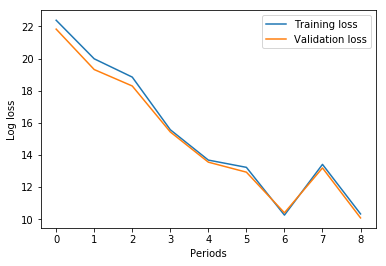

Final accuracy on validation data:  0.708


No handles with labels found to put in legend.


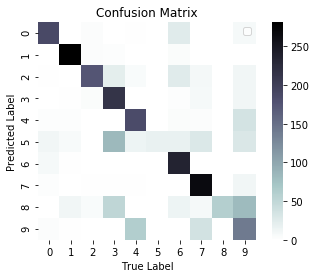

In [76]:
classifier = train_linear_classification_model(training_examples, training_targets,
                                              validation_examples, validation_targets,
                                              steps = 200, learning_rate = 0.05, batch_size = 5)

In [9]:
def train_DNN_classification_model(training_examples, training_targets, validation_examples, 
                                     validation_targets, steps, learning_rate, batch_size, hidden_units):
    #create input functions
    training_input_fn = create_training_input_fn(training_examples,training_targets)
    predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, 
                                                        batch_size)
    predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets,
                                                         batch_size)
    
    #configure linear classifier
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnnclassifier = tf.estimator.DNNClassifier(feature_columns=construct_feature_columns(), optimizer=my_optimizer, 
                                                      n_classes=10, hidden_units = hidden_units)
    
    periods = 10
    steps_per_period = steps/periods
    training_loss = []
    validation_loss = []
    for period in range(1,periods):
        dnnclassifier.train(input_fn = training_input_fn, steps = steps_per_period)
        
        #take a break and compute metrics
        training_predictions = list(dnnclassifier.predict(input_fn= predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_ids = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_ids,10)
        
        validation_predictions = list(dnnclassifier.predict(input_fn= predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_ids = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_ids,10)
                
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        print("Period: ",period)
        print("Validation log loss: ", validation_log_loss)
        #print("validation_pred_one_hot :", validation_pred_one_hot)
        training_loss.append(training_log_loss)
        validation_loss.append(validation_log_loss)
    final_predictions = dnnclassifier.predict(input_fn=predict_validation_input_fn)
    final_predictions_classids = np.array([item['class_ids'][0] for item in final_predictions])
    
    #Plot training and validation log loss over different periods
    
    plt.xlabel("Periods")
    plt.ylabel("Log loss")
    plt.plot(training_loss, label="Training loss")
    plt.plot(validation_loss, label="Validation loss")
    plt.legend()
    plt.show()
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions_classids)
    print("Final accuracy on validation data: ", accuracy)
    
    cm = metrics.confusion_matrix(validation_targets, final_predictions_classids)
    #plot confusion matrix
    ax = sns.heatmap(cm, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion Matrix")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.legend()
    plt.show()
    return dnnclassifier

Period:  1
Validation log loss:  7.9853651025033585
Period:  2
Validation log loss:  4.863059716403432
Period:  3
Validation log loss:  4.669642568591933
Period:  4
Validation log loss:  4.642011547476005
Period:  5
Validation log loss:  5.028845843099004
Period:  6
Validation log loss:  3.6611102978605414
Period:  7
Validation log loss:  3.3709845761432917
Period:  8
Validation log loss:  3.4538776394910777
Period:  9
Validation log loss:  2.8736261960565774


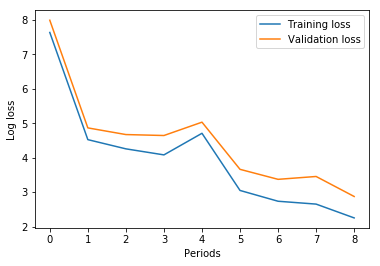

No handles with labels found to put in legend.


Final accuracy on validation data:  0.9168


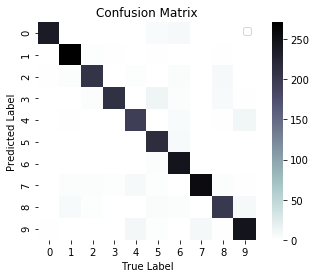

In [10]:
dnn_classifier = train_DNN_classification_model(training_examples, training_targets, validation_examples, validation_targets,
                                               steps = 10000, learning_rate = 0.05, batch_size = 20, hidden_units = [50,100,150,200])